Calculate climate sensitivity from 4xCO2 run

In [1]:
import xarray as xr
import numpy as np
import scipy
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import re
%matplotlib inline

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 104
Total threads: 104,Total memory: 496.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32905,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37073,Total threads: 1
Dashboard: /proxy/34947/status,Memory: 4.77 GiB
Nanny: tcp://127.0.0.1:44821,


In [4]:
archive_4x = Path('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d')
archive_pi = Path('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814')
archive_4xc5 = Path('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100')
archive_pic5 = Path('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed')

esm15_picontrol = Path('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1')
area = xr.open_dataset(esm15_picontrol / 'fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc').areacella

In [5]:
def get_dataset(archive, startyr=0, nyears=150):
    # Restricting it to just the required fields is much faster and also avoids problems
    # with multiple time axes.
    reqd = ['fld_s03i332', # rlut
        'fld_s01i207', # rsdt
        'fld_s01i208', # rsut
        'fld_s01i209', # rsutcs
        'fld_s00i031', # siconc
        'fld_s02i206', # rlutcs
        'fld_s03i236', # tas
        'time_bnds', 'lon_bnds', 'lat_bnds'
    ]

    def _preprocess(d):
        return xr.Dataset({v:d[v] for v in reqd}).load()

    file_list = []
    ny = 0  # Number of years
    # To match year in a filename
    reg_year = re.compile('.*-(\d{4})\d{2}_mon.nc')
    for ayr in itertools.count():
        atm_dir = archive / f'output{ayr:03d}/atmosphere'
        if not atm_dir.exists():
            print(f"{atm_dir} doesn't exist?")
            break
        netcdf_dir = atm_dir / 'netCDF'
        name_list = sorted(netcdf_dir.glob('aiihca.pa*.nc'))
        print(name_list)
        # Get the year number from the filename
        year = int(reg_year.match(name_list[0].name).group(1))
        if year < startyr:
            continue
        if len(name_list) == 12:
            file_list += name_list
            ny += 1
        else:
            # raise Exception(f'Unexpected number of monthly files in {netcdf_dir}')
            print(f'Unexpected {len(name_list)} monthly files in {netcdf_dir}')
        if ny >= nyears:
            break
    print("Processing range", file_list[0].name, file_list[-1].name, len(file_list))

    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    d = xr.open_mfdataset(file_list, combine='by_coords', decode_times=time_coder, preprocess=_preprocess, parallel = True)
    return d

In [6]:
def global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    # Check the shapes match
    assert ds.shape[-2:] == weights.shape, 'Shape mismatch in global_mean'
    assert ds.dims[-2:] == weights.dims, 'Coordinate mismatch in global_mean'
    dims = weights.dims
    if (weights[dims[0]]==ds[dims[0]]).all() and (weights[dims[1]]==ds[dims[1]]).all():
        ds_w = ds.weighted(weights)
    elif np.allclose(weights[dims[0]].data,ds[dims[0]].data) and np.allclose(weights[dims[1]].data,ds[dims[1]].data):
        ds_w = ds.weighted(weights.reindex_like(ds, method='nearest', tolerance=1e-4))
        # Warnings don't work properly?
        # print("Warning - non exact grid match")
        warnings.warn("Non exact grid match")
    else:
        raise ValueError("Grid mismatch")
    return ds_w.mean(dims)

def global_sum(ds,weights):
    """ Area weighted global mean of a DataArray"""
    # Check the shapes match
    assert ds.shape[-2:] == weights.shape, 'Shape mismatch in global_sum'
    assert ds.dims[-2:] == weights.dims, 'Coordinate mismatch in global_sum'
    dims = weights.dims
    if (weights[dims[0]]==ds[dims[0]]).all() and (weights[dims[1]]==ds[dims[1]]).all():
        ds_w = ds.weighted(weights)
    elif np.allclose(weights[dims[0]].data,ds[dims[0]].data) and np.allclose(weights[dims[1]].data,ds[dims[1]].data):
        ds_w = ds.weighted(weights.reindex_like(ds, method='nearest', tolerance=1e-4))
        # Warnings don't work properly?
        # print("Warning - non exact grid match")
        warnings.warn("Non exact grid match")
    else:
        raise ValueError("Grid mismatch")
    return ds_w.sum(dims)

def annual_mean(ds, original_time_axis=False):
    """ Properly month length weighted annual mean of a DataArray"""
    if not ds.time.dt.month[0] == 1:
        raise ValueError("Data does not start with January")
    if not ds.time.dt.month[1] == 2:
        raise ValueError("Non-monthly data")
    # Process only complete years
    nmon = 12*(len(ds.time)//12)
    month_length = ds.time.dt.days_in_month[:nmon]
    # Eventually use weighted ??? https://github.com/pydata/xarray/issues/3937
    weights = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    ann_mean = (ds[:nmon]*weights).groupby('time.year').sum(dim='time',min_count=1)
    if original_time_axis:
        ann_mean = ann_mean.assign_coords({'year':ds[:nmon].time.groupby('time.year').mean(dim='time')})
    return ann_mean

In [7]:
d_4x = get_dataset(archive_4x)
start_year = d_4x.time.values[0].year

[PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060201_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060202_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060203_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060204_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060205_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060206_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmosphere/netCDF/aiihca.pa-060207_mon.nc'), PosixPath('/scratch/p66/txz599/access-esm/archive/test_4xCO2-expt-862aa61d/output000/atmo

In [8]:
d_pi = get_dataset(archive_pi, start_year)

[PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010101_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010102_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010103_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010104_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010105_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010106_mon.nc'), PosixPath('/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814/output000/atmosphere/netCDF/aiihca.pa-010107_mon.nc'), PosixPath('/scratch/p66/jxs599/ac

In [9]:
d_4xc5 = get_dataset(archive_4xc5)

[PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078601_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078602_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078603_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078604_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078605_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078606_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO2-202504-cice5_restart100/output000/atmosphere/netCDF/aiihca.pa-078607_mon.nc'), PosixPath('/g/data/tm70/as2285/experiments/esm1.6-4xCO

In [10]:
start_year = d_4xc5.time.values[0].year

In [11]:
start_year

786

In [12]:
d_pic5 = get_dataset(archive_pic5, start_year)

[PosixPath('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed/output000/atmosphere/netCDF/aiihca.pa-078601_mon.nc'), PosixPath('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed/output000/atmosphere/netCDF/aiihca.pa-078602_mon.nc'), PosixPath('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed/output000/atmosphere/netCDF/aiihca.pa-078603_mon.nc'), PosixPath('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed/output000/atmosphere/netCDF/aiihca.pa-078604_mon.nc'), PosixPath('/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed/output000/atmosphere/netCDF/aiihca.pa-078605_mon.nc'), PosixPath('/sc

2025-07-17 09:37:30,863 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.34 GiB -- Worker memory limit: 4.77 GiB


In [13]:
rsdt_4x = global_mean(annual_mean(d_4x['fld_s01i207']), area).compute()
rsut_4x = global_mean(annual_mean(d_4x['fld_s01i208']), area).compute()
rlut_4x = global_mean(annual_mean(d_4x['fld_s03i332']), area).compute()
rsutcs_4x = global_mean(annual_mean(d_4x['fld_s01i209']), area).compute()
rlutcs_4x = global_mean(annual_mean(d_4x['fld_s02i206']), area).compute()
tas_4x = global_mean(annual_mean(d_4x['fld_s03i236']), area).compute()
net_4x = rsdt_4x - rsut_4x - rlut_4x

In [14]:
rsdt_4xc5 = global_mean(annual_mean(d_4xc5['fld_s01i207']), area).compute()
rsut_4xc5 = global_mean(annual_mean(d_4xc5['fld_s01i208']), area).compute()
rlut_4xc5 = global_mean(annual_mean(d_4xc5['fld_s03i332']), area).compute()
rsutcs_4xc5 = global_mean(annual_mean(d_4xc5['fld_s01i209']), area).compute()
rlutcs_4xc5 = global_mean(annual_mean(d_4xc5['fld_s02i206']), area).compute()
tas_4xc5 = global_mean(annual_mean(d_4xc5['fld_s03i236']), area).compute()
net_4xc5 = rsdt_4xc5 - rsut_4xc5 - rlut_4xc5

In [15]:
rsdt_pi = global_mean(annual_mean(d_pi['fld_s01i207']), area).compute()
rsut_pi = global_mean(annual_mean(d_pi['fld_s01i208']), area).compute()
rlut_pi = global_mean(annual_mean(d_pi['fld_s03i332']), area).compute()
rsutcs_pi = global_mean(annual_mean(d_pi['fld_s01i209']), area).compute()
rlutcs_pi = global_mean(annual_mean(d_pi['fld_s02i206']), area).compute()
tas_pi = global_mean(annual_mean(d_pi['fld_s03i236']), area).compute()
net_pi = rsdt_pi - rsut_pi - rlut_pi

In [16]:
rsdt_pic5 = global_mean(annual_mean(d_pic5['fld_s01i207']), area).compute()
rsut_pic5 = global_mean(annual_mean(d_pic5['fld_s01i208']), area).compute()
rlut_pic5 = global_mean(annual_mean(d_pic5['fld_s03i332']), area).compute()
rsutcs_pic5 = global_mean(annual_mean(d_pic5['fld_s01i209']), area).compute()
rlutcs_pic5 = global_mean(annual_mean(d_pic5['fld_s02i206']), area).compute()
tas_pic5 = global_mean(annual_mean(d_pic5['fld_s03i236']), area).compute()
net_pic5 = rsdt_pic5 - rsut_pic5 - rlut_pic5

In [17]:
vars_pi = {
    'rsdt': rsdt_pi,
    'rsut': rsut_pi,
    'rlut': rlut_pi,
    'rsutcs': rsutcs_pi,
    'rlutcs': rlutcs_pi,
    'tas': tas_pi
}
vars_pic5 = {
    'rsdt': rsdt_pic5,
    'rsut': rsut_pic5,
    'rlut': rlut_pic5,
    'rsutcs': rsutcs_pic5,
    'rlutcs': rlutcs_pic5,
    'tas': tas_pic5
}
vars_4x = {
    'rsdt': rsdt_4x,
    'rsut': rsut_4x,
    'rlut': rlut_4x,
    'rsutcs': rsutcs_4x,
    'rlutcs': rlutcs_4x,
    'tas': tas_4x
}
vars_4xc5 = {
    'rsdt': rsdt_4xc5,
    'rsut': rsut_4xc5,
    'rlut': rlut_4xc5,
    'rsutcs': rsutcs_4xc5,
    'rlutcs': rlutcs_4xc5,
    'tas': tas_4xc5
}

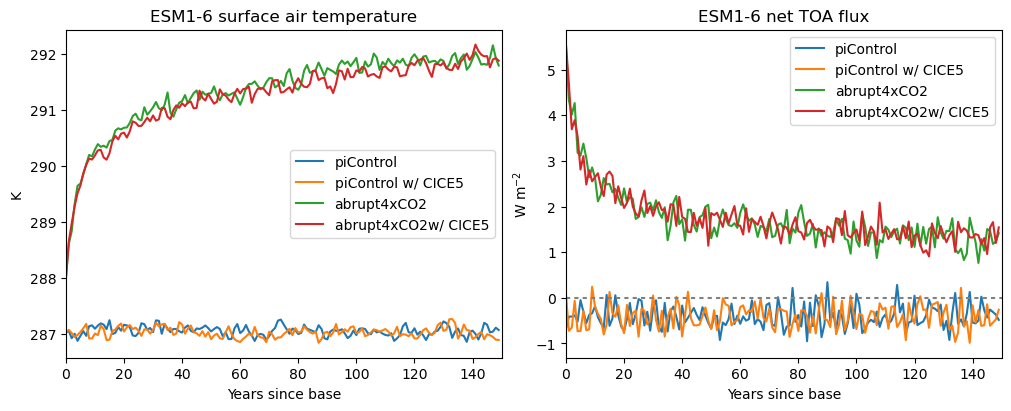

In [18]:
fig, axes = plt.subplots(1,2,layout='constrained',figsize=(10,4))
ax = axes[0]
ax.plot(tas_pi, label='piControl')
ax.plot(tas_pic5, label='piControl w/ CICE5')
ax.plot(tas_4x, label='abrupt4xCO2')
ax.plot(tas_4xc5, label='abrupt4xCO2w/ CICE5')
ax.set_title('ESM1-6 surface air temperature')
ax.set_xlabel('Years since base')
ax.set_ylabel('K')
ax.set_xlim(0,150)
ax.legend()
ax = axes[1]
ax.plot(net_pi, label='piControl')
ax.plot(net_pic5, label='piControl w/ CICE5')
ax.plot(net_4x, label='abrupt4xCO2')
ax.plot(net_4xc5, label='abrupt4xCO2w/ CICE5')
ax.set_title('ESM1-6 net TOA flux')
ax.set_xlabel('Years since base')
ax.set_ylabel('W m$^{-2}$')
ax.axhline(color='gray', dashes=[2,2])
ax.set_xlim(0,150)
ax.legend()
# plt.savefig('esm16_4xCO2.png')

In [19]:
def analyse(vars_c, vars_4, len4=150, cre=False, verbose=False):

    # Expect global means for matching time period in vars

    rsdt_c = vars_c['rsdt']
    rsut_c = vars_c['rsut']
    rlut_c = vars_c['rlut']
    tas_c = vars_c['tas']
    rsdt_4 = vars_4['rsdt'][:len4]
    rsut_4 = vars_4['rsut'][:len4]
    rlut_4 = vars_4['rlut'][:len4]
    tas_4 = vars_4['tas'][:len4]

    net_c = rsdt_c - rsut_c - rlut_c
    len4 = min(len4, len(tas_4))
    net_4 = rsdt_4 - rsut_4 - rlut_4

    # Fit a line to the control net flux
    t = np.arange(len(net_c))
    an, bn = np.polyfit(t,net_c,1)
    net_fit = np.polyval([an,bn], t)

    at, bt = np.polyfit(t,tas_c,1)
    tas_fit = np.polyval([at,bt], t)

    if verbose:
        print("Net fit", an, bn)
        print("Tas fit", at, bt)

    # Anomalies

    tas_anom = tas_4 - tas_fit[:len4]
    net_anom = net_4 - net_fit[:len4]

    # r, p = scipy.stats.pearsonr(tas_anom,net_anom)
    a,b,r,p,err = scipy.stats.linregress(tas_anom[:],net_anom[:])
    result = {}
    result['tas_anom'] = tas_anom
    result['net_anom'] = net_anom
    result['fit_net'] = (a,b)

    if cre:

        rsutcs_c = vars_c['rsutcs']
        rlutcs_c = vars_c['rlutcs']
        rsutcs_4 = vars_4['rsutcs'][:len4]
        rlutcs_4 = vars_4['rlutcs'][:len4]

        #  Clear sky LW
        ac, bc = np.polyfit(t,rlutcs_c,1)
        rlutcs_fit = np.polyval([ac,bc], t)
        # Flip sign to give net flux into atm
        result['rlutcs_anom'] = -(rlutcs_4 - rlutcs_fit[:len4])
        a,b,r,p,err = scipy.stats.linregress(tas_anom,result['rlutcs_anom'])
        result['fit_rlutcs'] = (a,b)

        # Clear sky SW
        ac, bc = np.polyfit(t,rsutcs_c,1)
        rsutcs_fit = np.polyval([ac,bc], t)
        # Flip sign to give net flux into atm
        result['rsutcs_anom'] = -(rsutcs_4 - rsutcs_fit[:len4])
        a,b,r,p,err = scipy.stats.linregress(tas_anom,result['rsutcs_anom'])
        result['fit_rsutcs'] = (a,b)

        result['cs_anom'] = result['rlutcs_anom'] + result['rsutcs_anom']
        a1, b1 = result['fit_rlutcs']
        a2, b2 = result['fit_rsutcs']
        result['fit_cs'] = (a1+a2, b1+b2)

        # Cloud radiative effect
        # Difference between all sky and clear sky net down
        # All sky net down rsdt - rsut - rlut
        # Clear sky rsdt - rsutcs - rlutcs
        cre_c = rsutcs_c + rlutcs_c - rsut_c - rlut_c
        cre_4 = rsutcs_4 + rlutcs_4 - rsut_4 - rlut_4
        lwcre_c = rlutcs_c - rlut_c
        swcre_c = rsutcs_c - rsut_c
        cre_4 = rsutcs_4 + rlutcs_4 - rsut_4 - rlut_4
        lwcre_4 = rlutcs_4 - rlut_4
        swcre_4 = rsutcs_4 - rsut_4
        a, b = np.polyfit(t,cre_c,1)
        cre_fit = np.polyval([a,b], t)
        result['cre_anom']= cre_4 - cre_fit[:len4]
        a,b,r,p,err = scipy.stats.linregress(tas_anom,result['cre_anom'])
        result['fit_cre'] = (a,b)
        a, b = np.polyfit(t,lwcre_c,1)
        lwcre_fit = np.polyval([a,b], t)
        result['lwcre_anom'] = lwcre_4 - lwcre_fit[:len4]
        a,b,r,p,err = scipy.stats.linregress(tas_anom,result['lwcre_anom'])
        result['fit_lwcre'] = (a,b)

        a, b = np.polyfit(t,swcre_c,1)
        swcre_fit = np.polyval([a,b], t)
        result['swcre_anom'] = swcre_4 - swcre_fit[:len4]
        a,b,r,p,err = scipy.stats.linregress(tas_anom,result['swcre_anom'])
        result['fit_swcre'] = (a,b)

    return result


In [20]:
result = analyse(vars_pi, vars_4x, cre=True)

In [21]:
resultc5 = analyse(vars_pic5, vars_4xc5, cre=True)

In [22]:
def analysis_plot(result, axes, title):
    axes.scatter(result['tas_anom'], result['net_anom'])
    axes.set_ylim(-0.9,7)
    axes.set_xlim(0,8)
    a, b = result['fit_net']
    print(f'ECS {title} {-0.5*b/a:.3f}')
    net_fit = np.polyval([a,b], [0,10])
    axes.plot([0,10], net_fit, linewidth=2) #,color='black')
    axes.axhline(color='black', dashes=[2,2])
    axes.yaxis.set_minor_locator( mpl.ticker.MultipleLocator(0.5) )
    axes.xaxis.set_minor_locator( mpl.ticker.MultipleLocator(0.5) )
    axes.set_xlabel('Change in surface air temperature (K)')
    axes.set_ylabel('Change in net radiation (W$ m^{-2}$)')
    axes.set_title(title)

def analysis_plot_cre(result, axes, title, tmax=8):
    tas_anom = result['tas_anom']
    label = {'rlutcs':'LW clearsky', 'rsutcs':'SW clearsky', 'lwcre':'LW CRE', 'swcre':'SW CRE'}
    avals = {}
    for var in ['rlutcs', 'rsutcs', 'lwcre', 'swcre']:
        anom = result['%s_anom' % var]
        a, b = result['fit_%s' % var]
        avals[var] = a
        axes.scatter(tas_anom,anom,label=label[var])
        net_fit = np.polyval([a,b], np.arange(tmax+1))
        axes.plot(np.arange(tmax+1), net_fit, color='black', linewidth=2)
        axes.set_xlabel('Change in surface air temperature (K)')
        axes.set_ylabel('Change in TOA flux (W m$^{-2}$)')
        print('Fit %s %.3f %.3f' % (var, a, b))
    axes.legend()
    axes.grid(True)
    axes.set_ylim(-4,7)
    axes.set_xlim(0,tmax)
    axes.set_title(title)
    print(f"Clear sky {(avals['rlutcs']+avals['rsutcs']):.3f}")
    print(f"Total CRE {(avals['lwcre']+avals['swcre']):.3f}")
    print('Net fit %.3f %.3f' % result['fit_net'])

ECS ESM1-6 (150 years) 3.357
ECS ESM1-6 (150 years) 3.381


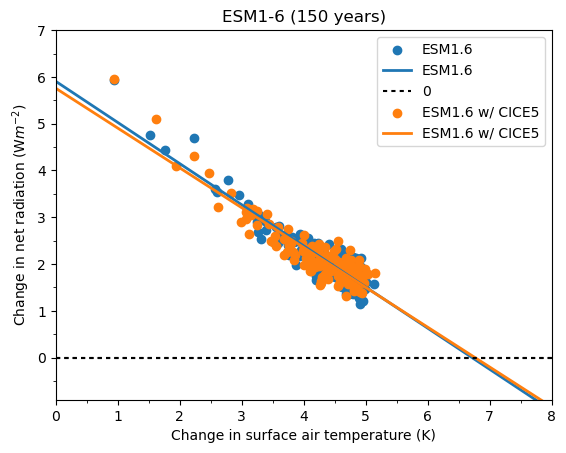

In [23]:
fig, axes = plt.subplots()
analysis_plot(result, axes, f'ESM1-6 ({len(result["tas_anom"])} years)')
analysis_plot(resultc5, axes, f'ESM1-6 ({len(resultc5["tas_anom"])} years)')
plt.legend(['ESM1.6','ESM1.6', '0', 'ESM1.6 w/ CICE5', 'ESM1.6 w/ CICE5'])

In [24]:
# Bootstrapping method to get confidence interval following Andrews et al 2012
# Samples with replacement from the anomalies

def calcCI(tas,net,ncases):
    # Random sampling to get CI
    n = len(tas)
    alist = []
    blist = []
    tlist = []
    rng = np.random.default_rng()
    for k in range(ncases):
        indices = rng.choice(n, n, replace=True)
        a,b,r,p,err = scipy.stats.linregress(tas[indices],net[indices])
        t = -b/a
        alist.append(a)
        blist.append(b)
        tlist.append(t)

    return alist, blist, tlist

def getstats(tas, net, nsamples=10000):
    # Anomalies
    A,B,T = calcCI(tas,net,nsamples)
    A = np.array(sorted(A))
    B = np.array(sorted(B))
    T = 0.5*np.array(sorted(T))
    for x in [A, B, T]:
        print("%6.2f  %6.3f  %6.2f  %6.2f  %6.2f" %
              ( x.mean(), x.std(), x[int(0.5*nsamples)], x[int(0.025*nsamples)], x[-int(0.025*nsamples)]))

In [25]:
getstats(result['tas_anom'], result['net_anom'])

 -0.87   0.051   -0.88   -0.96   -0.76
  5.87   0.223    5.89    5.39    6.26
  3.37   0.072    3.36    3.25    3.53


In [26]:
getstats(resultc5['tas_anom'], resultc5['net_anom'])

 -0.84   0.060   -0.85   -0.95   -0.71
  5.72   0.262    5.74    5.16    6.17
  3.40   0.093    3.39    3.25    3.61


Fit rlutcs -1.815 7.116
Fit rsutcs 0.658 -0.451
Fit lwcre -0.131 -1.408
Fit swcre 0.410 0.649
Clear sky -1.158
Total CRE 0.278
Net fit -0.880 5.906


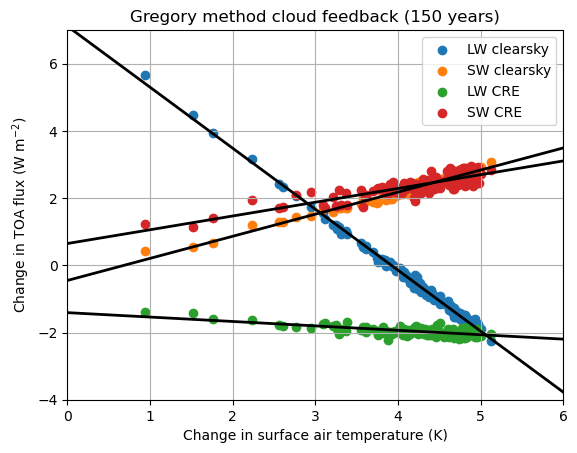

In [27]:
fig, axes = plt.subplots()
title = f'Gregory method cloud feedback ({len(result["tas_anom"])} years)'
analysis_plot_cre(result, axes, title, tmax=6)
# savefig(f'esm16_cloud_feedback_{len(result["tas_anom"])}.png')

Fit rlutcs -1.813 7.119
Fit rsutcs 0.659 -0.475
Fit lwcre -0.139 -1.389
Fit swcre 0.442 0.503
Clear sky -1.154
Total CRE 0.303
Net fit -0.851 5.757


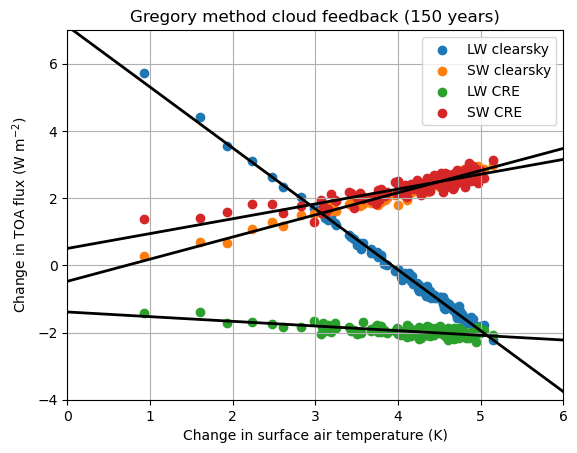

In [28]:
fig, axes = plt.subplots()
title = f'Gregory method cloud feedback ({len(result["tas_anom"])} years)'
analysis_plot_cre(resultc5, axes, title, tmax=6)
# savefig(f'esm16_cloud_feedback_{len(result["tas_anom"])}.png')

In [29]:
area_nh = area.copy()
area_nh[:72] = 0.
area_sh = area.copy()
area_sh[72:] = 0.
sice_4x = global_sum(annual_mean(d_4x['fld_s00i031']), area).compute()
sice_4xc5 = global_sum(annual_mean(d_4xc5['fld_s00i031']), area).compute()

sice_pi = global_sum(annual_mean(d_pi['fld_s00i031']), area).compute()
sice_pic5 = global_sum(annual_mean(d_pic5['fld_s00i031']), area).compute()

sice_4x_nh = global_sum(annual_mean(d_4x['fld_s00i031']), area_nh).compute()
sice_4xc5_nh = global_sum(annual_mean(d_4xc5['fld_s00i031']), area_nh).compute()

sice_pi_nh = global_sum(annual_mean(d_pi['fld_s00i031']), area_nh).compute()
sice_pic5_nh = global_sum(annual_mean(d_pic5['fld_s00i031']), area_nh).compute()

sice_4x_sh = global_sum(annual_mean(d_4x['fld_s00i031']), area_sh).compute()
sice_4xc5_sh = global_sum(annual_mean(d_4xc5['fld_s00i031']), area_sh).compute()

sice_pi_sh = global_sum(annual_mean(d_pi['fld_s00i031']), area_sh).compute()
sice_pic5_sh = global_sum(annual_mean(d_pic5['fld_s00i031']), area_sh).compute()



In [30]:
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
d = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/SImon/siconca/gn/latest/siconca_SImon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', decode_times=time_coder)
sice_pi_esm15 = 0.01*global_sum(annual_mean(d['siconca'][:150*12]), area).compute()
sice_pi_esm15_nh = 0.01*global_sum(annual_mean(d['siconca'][:150*12]), area_nh).compute()
sice_pi_esm15_sh = 0.01*global_sum(annual_mean(d['siconca'][:150*12]), area_sh).compute()
d = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/abrupt-4xCO2/r1i1p1f1/SImon/siconca/gn/latest/siconca_SImon_ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1_gn_010101-025012.nc', decode_times=time_coder)
sice_4x_esm15 = 0.01*global_sum(annual_mean(d['siconca']), area).compute()
sice_4x_esm15_nh = 0.01*global_sum(annual_mean(d['siconca']), area_nh).compute()
sice_4x_esm15_sh = 0.01*global_sum(annual_mean(d['siconca']), area_sh).compute()

d = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_ACCESS-ESM1-5_abrupt-4xCO2_r1i1p1f1_gn_010101-025012.nc', decode_times=time_coder)
tas_4x_esm15 = global_mean(annual_mean(d['tas']), area).compute()


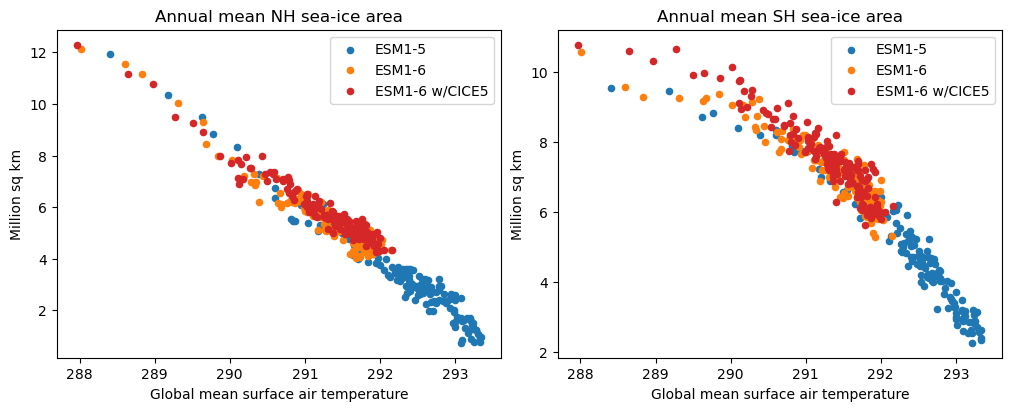

In [31]:
fig, axes = plt.subplots(1,2,layout='constrained',figsize=(10,4))
nt = len(tas_4x)
axes[0].scatter(tas_4x_esm15[:nt].data, 1e-12*sice_4x_esm15_nh[:nt].data, s=20, label='ESM1-5')
axes[0].scatter(tas_4x_esm15[nt:].data, 1e-12*sice_4x_esm15_nh[nt:].data, s=20, color='C2')
axes[0].scatter(tas_4x.data, 1e-12*sice_4x_nh.data, s=20, label='ESM1-6',color='C1')
axes[0].scatter(tas_4xc5.data, 1e-12*sice_4xc5_nh.data, s=20, label='ESM1-6 w/CICE5',color='C3')
axes[0].set_xlabel('Global mean surface air temperature')
axes[0].set_ylabel('Million sq km')
axes[0].set_title('Annual mean NH sea-ice area')
axes[0].legend()

axes[1].scatter(tas_4x_esm15[:nt].data, 1e-12*sice_4x_esm15_sh[:nt].data, s=20, label='ESM1-5')
axes[1].scatter(tas_4x_esm15[nt:].data, 1e-12*sice_4x_esm15_sh[nt:].data, s=20, color='C2')
axes[1].scatter(tas_4x.data, 1e-12*sice_4x_sh.data, s=20, label='ESM1-6', color='C1')
axes[1].scatter(tas_4xc5.data, 1e-12*sice_4xc5_sh.data, s=20, label='ESM1-6 w/CICE5', color='C3')

axes[1].set_xlabel('Global mean surface air temperature')
axes[1].set_ylabel('Million sq km')
axes[1].set_title('Annual mean SH sea-ice area')
axes[1].legend()
# plt.savefig(f'sea_ice_esm16_{len(tas_4x)}.png')

In [32]:
client.close()